In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lag, sum as spark_sum
from pyspark.sql.window import Window


In [ ]:
# Use the file path provided in the Spark API Format
file_path = "dbfs:/FileStore/tables/updated_combined_laps_20_sessions_v2.csv"  # Replace with your actual file path

# Load the dataset with the path and Spark API options
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(file_path)

# Display the schema to confirm successful loading
df.printSchema()


root
 |-- Time: string (nullable = true)
 |-- Driver: string (nullable = true)
 |-- DriverNumber: integer (nullable = true)
 |-- LapTime: string (nullable = true)
 |-- LapNumber: double (nullable = true)
 |-- Stint: double (nullable = true)
 |-- PitOutTime: string (nullable = true)
 |-- PitInTime: string (nullable = true)
 |-- Sector1Time: string (nullable = true)
 |-- Sector2Time: string (nullable = true)
 |-- Sector3Time: string (nullable = true)
 |-- Sector1SessionTime: string (nullable = true)
 |-- Sector2SessionTime: string (nullable = true)
 |-- Sector3SessionTime: string (nullable = true)
 |-- SpeedI1: double (nullable = true)
 |-- SpeedI2: double (nullable = true)
 |-- SpeedFL: double (nullable = true)
 |-- SpeedST: double (nullable = true)
 |-- IsPersonalBest: boolean (nullable = true)
 |-- Compound: string (nullable = true)
 |-- TyreLife: double (nullable = true)
 |-- FreshTyre: boolean (nullable = true)
 |-- Team: string (nullable = true)
 |-- LapStartTime: string (nullable 

In [ ]:
# Show the first few rows of the dataset
df.show(5)


+--------------------+------+------------+--------------------+---------+-----+----------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+-------+-------+-------+--------------+--------+--------+---------+---------------+--------------------+--------------------+-----------+--------+-------+-------------+---------------+----------+----+-----+-----------+-------+------------------+---------------+--------------+------------------+-------------+--------------+--------------+
|                Time|Driver|DriverNumber|             LapTime|LapNumber|Stint|PitOutTime|PitInTime|         Sector1Time|         Sector2Time|         Sector3Time|  Sector1SessionTime|  Sector2SessionTime|  Sector3SessionTime|SpeedI1|SpeedI2|SpeedFL|SpeedST|IsPersonalBest|Compound|TyreLife|FreshTyre|           Team|        LapStartTime|        LapStartDate|TrackStatus|Position|Deleted|DeletedReason|FastF1Generated|IsAccura

In [ ]:
# Fill missing values in essential columns
df = df.na.fill({
    "Tyre Wear": 0,
    "LapTimeSeconds": 0,
    "Track Temperature": 0,
    "Air Temperature": 0
})


In [ ]:
# Create a target column "IsPitLap" indicating if the lap includes a pit stop
df = df.withColumn("IsPitLap", when(col("Pit Stop Time") > 0, 1).otherwise(0))


In [ ]:
# Define a window partitioned by Driver and SessionType and ordered by LapNumber
window_spec = Window.partitionBy("Driver", "SessionType").orderBy("LapNumber")

# Create cumulative tyre wear feature
df = df.withColumn("CumulativeTyreWear", spark_sum("Tyre Wear").over(window_spec))


In [ ]:
# Add lag features for previous lap's tyre wear and lap time
df = df.withColumn("PrevTyreWear", lag("Tyre Wear", 1).over(window_spec))
df = df.withColumn("PrevLapTime", lag("LapTimeSeconds", 1).over(window_spec))

# Replace nulls in lagged columns with 0 for the first lap
df = df.na.fill({"PrevTyreWear": 0, "PrevLapTime": 0})


In [ ]:
# Select features and target for model training
selected_features = [
    "LapNumber", "LapTimeSeconds", "Track Temperature", "Air Temperature",
    "Tyre Wear", "CumulativeTyreWear", "PrevTyreWear", "PrevLapTime", "IsPitLap"
]

final_df = df.select(*selected_features)
final_df.show(5)


+---------+--------------+------------------+---------------+------------------+------------------+------------------+-----------+--------+
|LapNumber|LapTimeSeconds| Track Temperature|Air Temperature|         Tyre Wear|CumulativeTyreWear|      PrevTyreWear|PrevLapTime|IsPitLap|
+---------+--------------+------------------+---------------+------------------+------------------+------------------+-----------+--------+
|      1.0|        90.785|29.916515232847765|           27.0| 22.13873386213415| 352.9092405830954|               0.0|        0.0|       0|
|      1.0|       101.364| 26.16355264556595|           16.0| 18.58048882213954| 352.9092405830954| 22.13873386213415|     90.785|       0|
|      1.0|       106.453|28.038082630813616|           23.0|16.917089498313494| 352.9092405830954| 18.58048882213954|    101.364|       0|
|      1.0|       103.346|27.816914301818084|            0.0| 20.65921244547879| 352.9092405830954|16.917089498313494|    106.453|       0|
|      1.0|        9

In [ ]:
# Clean column names by replacing spaces with underscores
final_df = final_df.select([col(c).alias(c.replace(" ", "_")) for c in final_df.columns])

# Now, save the DataFrame as a Databricks table
final_df.write.format("delta").saveAsTable("final_pit_stop_data")


In [ ]:
# Load and show the saved table
processed_data = spark.sql("SELECT * FROM final_pit_stop_data")
processed_data.show(50)


+---------+--------------+------------------+---------------+------------------+------------------+------------------+-----------+--------+
|LapNumber|LapTimeSeconds| Track_Temperature|Air_Temperature|         Tyre_Wear|CumulativeTyreWear|      PrevTyreWear|PrevLapTime|IsPitLap|
+---------+--------------+------------------+---------------+------------------+------------------+------------------+-----------+--------+
|      1.0|        90.785|29.916515232847765|           27.0| 22.13873386213415| 352.9092405830954|               0.0|        0.0|       0|
|      1.0|       101.364| 26.16355264556595|           16.0| 18.58048882213954| 352.9092405830954| 22.13873386213415|     90.785|       0|
|      1.0|       106.453|28.038082630813616|           23.0|16.917089498313494| 352.9092405830954| 18.58048882213954|    101.364|       0|
|      1.0|       103.346|27.816914301818084|            0.0| 20.65921244547879| 352.9092405830954|16.917089498313494|    106.453|       0|
|      1.0|        9

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
from pyspark.sql import functions as F

# Create interaction terms
data = data.withColumn("LapTime_TyreWear", F.col("LapTimeSeconds") * F.col("Tyre_Wear"))
data = data.withColumn("Temp_TyreWear", F.col("Track_Temperature") * F.col("Tyre_Wear"))


In [ ]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Define the window for rolling average (last 3 laps)
window_spec = Window.orderBy("LapNumber").rowsBetween(-3, 0)

# Calculate the rolling average of lap time
data = data.withColumn("Rolling_Avg_LapTime", F.avg("LapTimeSeconds").over(window_spec))


In [ ]:
data.printSchema()  # Verify the new columns are present


root
 |-- LapNumber: double (nullable = true)
 |-- LapTimeSeconds: double (nullable = true)
 |-- Track_Temperature: double (nullable = true)
 |-- Air_Temperature: double (nullable = true)
 |-- Tyre_Wear: double (nullable = true)
 |-- CumulativeTyreWear: double (nullable = true)
 |-- PrevTyreWear: double (nullable = true)
 |-- PrevLapTime: double (nullable = true)
 |-- IsPitLap: integer (nullable = true)
 |-- LapTime_TyreWear: double (nullable = true)
 |-- Temp_TyreWear: double (nullable = true)
 |-- Rolling_Avg_LapTime: double (nullable = true)



In [ ]:
# Define feature columns without LapNumber
feature_columns_without_lapnumber = [
    "LapTimeSeconds",
    "Tyre_Wear",
    "CumulativeTyreWear",
    "Track_Temperature",
    "Air_Temperature",
    "PrevLapTime",
    "PrevTyreWear",
    "LapTime_TyreWear",  # Interaction term added
    "Temp_TyreWear",     # Interaction term added
    "Rolling_Avg_LapTime" # Rolling average if created
]


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Assemble features without LapNumber
assembler = VectorAssembler(inputCols=feature_columns_without_lapnumber, outputCol="features_without_lapnumber")

# Apply StandardScaler to the assembled features
scaler = StandardScaler(inputCol="features_without_lapnumber", outputCol="scaledFeaturesWithoutLapNumber", withMean=True, withStd=True)


In [ ]:
# Split the data into training and test sets (80% training, 20% testing)
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)


In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Create interaction terms
data = data.withColumn("LapTime_TyreWear", F.col("LapTimeSeconds") * F.col("Tyre_Wear"))
data = data.withColumn("Temp_TyreWear", F.col("Track_Temperature") * F.col("Tyre_Wear"))

# Define the window for calculating the rolling average of lap time (last 3 laps)
window_spec = Window.orderBy("LapNumber").rowsBetween(-3, 0)

# Calculate the rolling average of lap time
data = data.withColumn("Rolling_Avg_LapTime", F.avg("LapTimeSeconds").over(window_spec))

# Verify that the new columns have been added
data.select("LapTime_TyreWear", "Temp_TyreWear", "Rolling_Avg_LapTime").show(5)


+------------------+-----------------+-------------------+
|  LapTime_TyreWear|    Temp_TyreWear|Rolling_Avg_LapTime|
+------------------+-----------------+-------------------+
|2009.8649536738487|662.3137688224989|             90.785|
|1883.3926689673524|486.1315974783975|            96.0745|
|1800.8749283639665| 474.322753226583|  99.53399999999999|
| 2135.046969390451|574.6755421389371|            100.487|
|1879.7128684396162|595.3409794528974|           100.8595|
+------------------+-----------------+-------------------+
only showing top 5 rows



In [ ]:
# Make predictions on the test data
predictions = model.transform(test_data)
predictions.select("LapNumber", "prediction").show(50)


+---------+------------------+
|LapNumber|        prediction|
+---------+------------------+
|      1.0|2.0804667686458305|
|      1.0|2.9641012406073926|
|      1.0|2.3874156038785688|
|      1.0| 2.294681867474716|
|      1.0|2.1895324372465614|
|      1.0| 2.253095953556546|
|      1.0| 1.845534888511224|
|      1.0| 1.195809270296647|
|      1.0|  1.32771723584915|
|      1.0|0.7762763572393626|
|      1.0|2.4046202778979864|
|      1.0| 1.963350707223359|
|      1.0|  1.06982405802336|
|      1.0|1.0336844034185046|
|      1.0|1.3139794319845177|
|      1.0|1.1543837170431752|
|      1.0| 1.176938915900001|
|      1.0|1.2512033930454791|
|      1.0|1.3318547831444492|
|      1.0|1.8857061305910927|
|      1.0|1.0921682615556316|
|      1.0|0.9827217103906077|
|      1.0|1.2057192715890888|
|      1.0|1.2365228159225108|
|      1.0|1.6913972923796308|
|      1.0|1.2206887888725153|
|      1.0|1.1661894082223898|
|      1.0|1.5934489823357867|
|      1.0|1.6424374717183825|
|      1

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize evaluators for RMSE and R2
evaluator_rmse = RegressionEvaluator(labelCol="LapNumber", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="LapNumber", predictionCol="prediction", metricName="r2")

# Calculate RMSE and R2
rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"RMSE without LapNumber: {rmse}")
print(f"R2 without LapNumber: {r2}")


RMSE without LapNumber: 1.9136065281323962
R2 without LapNumber: 0.9893536699494738


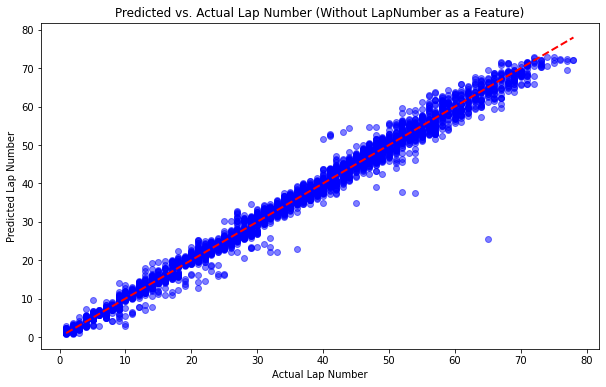

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert predictions to Pandas DataFrame for plotting
preds_pd = predictions.select("LapNumber", "prediction").toPandas()

# Plot Predictions vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(preds_pd["LapNumber"], preds_pd["prediction"], alpha=0.5, color='blue')
plt.plot([preds_pd["LapNumber"].min(), preds_pd["LapNumber"].max()],
         [preds_pd["LapNumber"].min(), preds_pd["LapNumber"].max()], 'r--', lw=2)
plt.xlabel("Actual Lap Number")
plt.ylabel("Predicted Lap Number")
plt.title("Predicted vs. Actual Lap Number (Without LapNumber as a Feature)")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the trained GBT model from the pipeline stages
gbt_model = model.stages[-1]  # The last stage is the GBT model

# Retrieve feature importances as a dense array
feature_importances = gbt_model.featureImportances.toArray()

# Define the feature names (ensure these match the features used in the model)
feature_columns_without_lapnumber = [
    "LapTimeSeconds", "Tyre_Wear", "CumulativeTyreWear", "Track_Temperature",
    "Air_Temperature", "PrevLapTime", "PrevTyreWear", "LapTime_TyreWear",
    "Temp_TyreWear", "Rolling_Avg_LapTime"
]

# Create a DataFrame for feature importances for easier plotting
importance_df = pd.DataFrame({
    'Feature': feature_columns_without_lapnumber,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


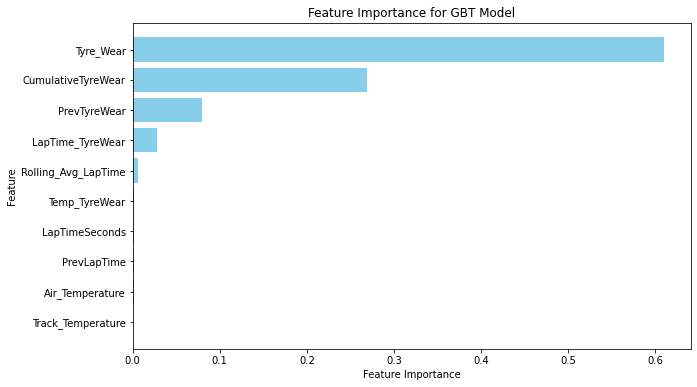

In [ ]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for GBT Model")
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()


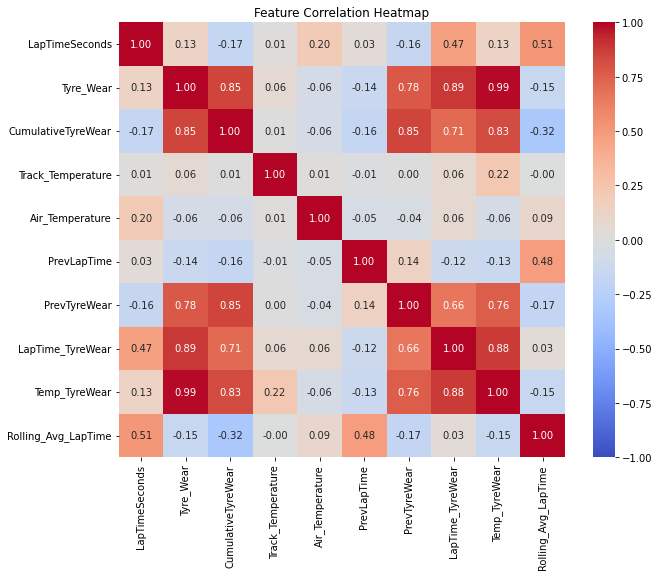

In [ ]:
import seaborn as sns
import numpy as np

# Convert the Spark DataFrame to Pandas for easier plotting with Seaborn
data_pd = data.select(feature_columns_without_lapnumber).toPandas()

# Compute the correlation matrix
corr_matrix = data_pd.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()


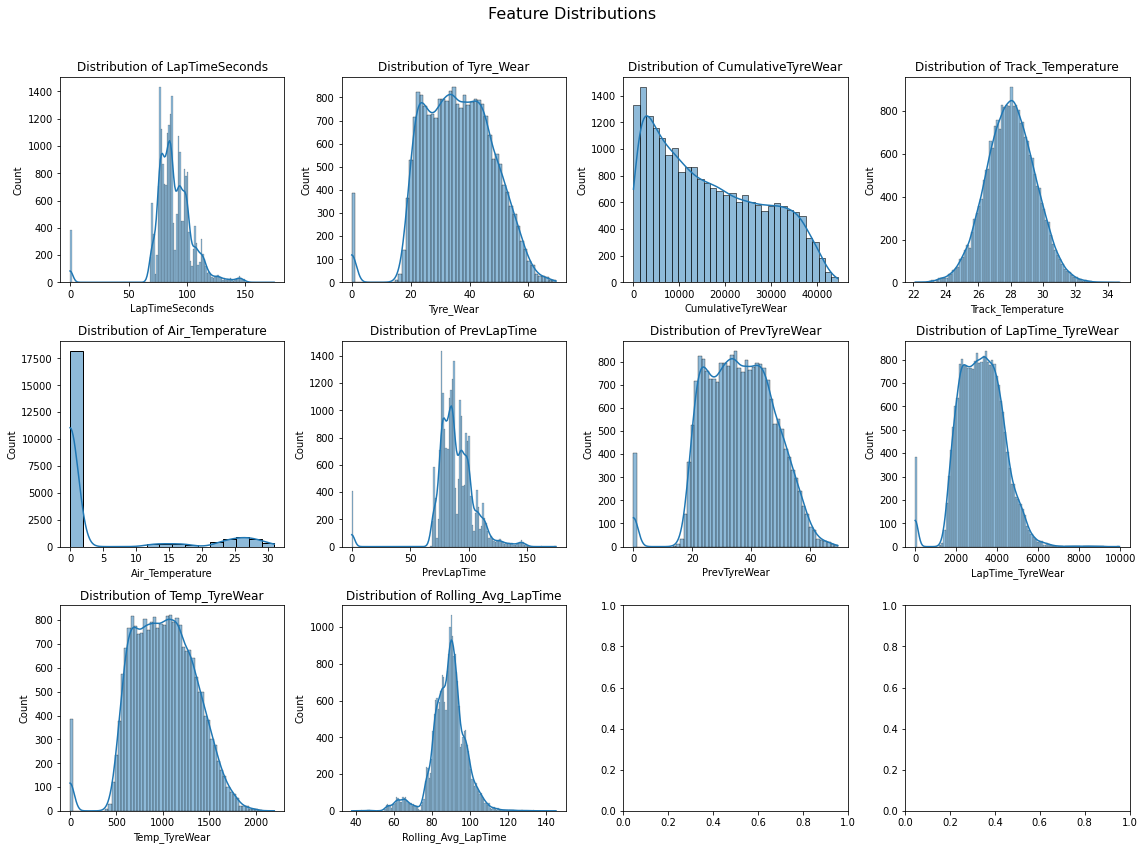

In [ ]:
# Plot the distribution of each feature
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
fig.suptitle("Feature Distributions", fontsize=16)

for i, feature in enumerate(feature_columns_without_lapnumber):
    row, col = divmod(i, 4)
    sns.histplot(data_pd[feature], kde=True, ax=axes[row][col])
    axes[row][col].set_title(f"Distribution of {feature}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


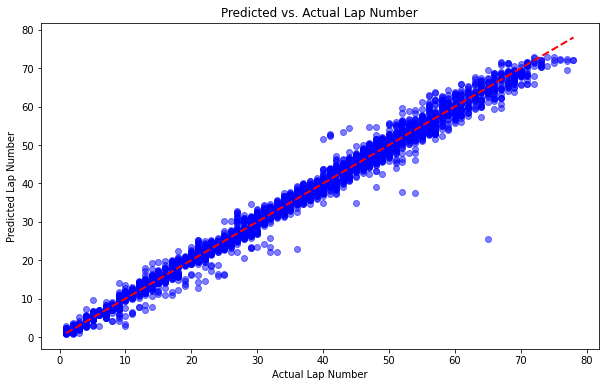

In [ ]:
# Convert predictions to Pandas DataFrame for plotting
predictions_pd = predictions.select("LapNumber", "prediction").toPandas()

# Plot Predictions vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["LapNumber"], predictions_pd["prediction"], alpha=0.5, color='blue')
plt.plot([predictions_pd["LapNumber"].min(), predictions_pd["LapNumber"].max()],
         [predictions_pd["LapNumber"].min(), predictions_pd["LapNumber"].max()], 'r--', lw=2)
plt.xlabel("Actual Lap Number")
plt.ylabel("Predicted Lap Number")
plt.title("Predicted vs. Actual Lap Number")
plt.show()


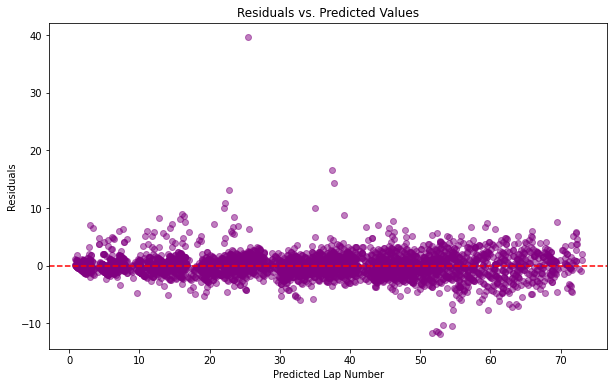

In [ ]:
# Calculate residuals
predictions_pd["Residuals"] = predictions_pd["LapNumber"] - predictions_pd["prediction"]

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["prediction"], predictions_pd["Residuals"], alpha=0.5, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Lap Number")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()


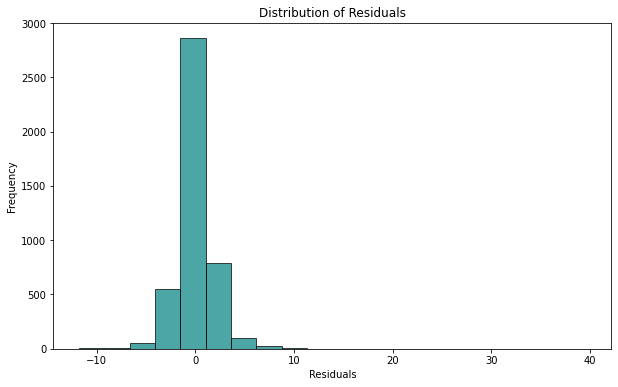

In [ ]:
# Plot histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(predictions_pd["Residuals"], bins=20, color='teal', edgecolor='black', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()


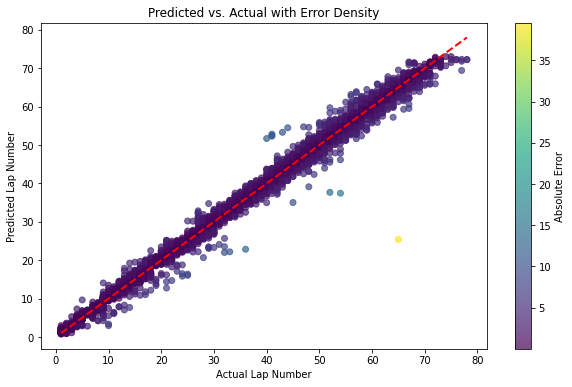

In [ ]:
# Calculate absolute error
predictions_pd["Absolute_Error"] = predictions_pd["Residuals"].abs()

# Scatter plot with color density for errors
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["LapNumber"], predictions_pd["prediction"], c=predictions_pd["Absolute_Error"], cmap='viridis', alpha=0.7)
plt.colorbar(label="Absolute Error")
plt.plot([predictions_pd["LapNumber"].min(), predictions_pd["LapNumber"].max()],
         [predictions_pd["LapNumber"].min(), predictions_pd["LapNumber"].max()], 'r--', lw=2)
plt.xlabel("Actual Lap Number")
plt.ylabel("Predicted Lap Number")
plt.title("Predicted vs. Actual with Error Density")
plt.show()


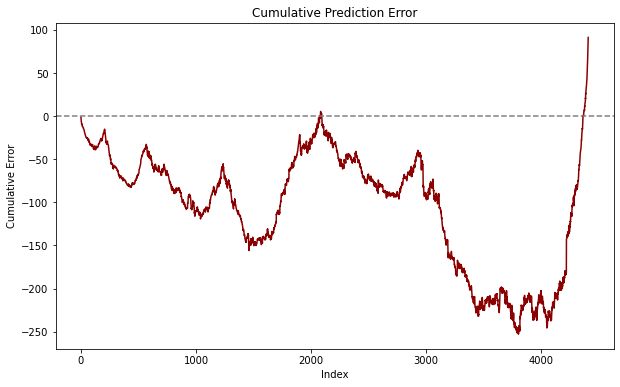

In [ ]:
# Calculate cumulative error
predictions_pd["Cumulative_Error"] = predictions_pd["Residuals"].cumsum()

# Plot cumulative error
plt.figure(figsize=(10, 6))
plt.plot(predictions_pd.index, predictions_pd["Cumulative_Error"], color='darkred')
plt.xlabel("Index")
plt.ylabel("Cumulative Error")
plt.title("Cumulative Prediction Error")
plt.axhline(y=0, color='grey', linestyle='--')
plt.show()
